# 🚀 Introduction to Denoising Diffusion Probabilistic Models (DDPM)

---

## 📘 What is DDPM?

**Denoising Diffusion Probabilistic Models (DDPM)** are a class of generative models that learn to model complex data distributions (e.g., images) by simulating a gradual noising and denoising process.

### ✅ How it works:
- **Forward Process:** Gradually corrupts data into pure Gaussian noise through a series of diffusion steps.
- **Reverse Process:** A neural network learns to reverse this process — denoising step by step to generate new data.

DDPM has shown impressive results in image generation tasks, achieving or surpassing the performance of GANs while offering better training stability and likelihood estimation.

---

## 🏗️ Techniques Used in This Project

---

### 🔥 1. **Sinusoidal Positional Embedding**

- Encodes the discrete diffusion timestep into a continuous high-dimensional vector.
- Provides the model with temporal awareness — it knows "how noisy" the input is at any point.
- Inspired by Transformer positional encoding.

---

### 🔥 2. **Time-Conditional Residual Blocks**

- Core component of the U-Net architecture.
- Incorporates the time embedding into every residual block via feature-wise addition.
- Allows the model to adapt its behavior dynamically depending on the timestep.

---

### 🔥 3. **U-Net Architecture**

- A symmetric encoder-decoder structure with skip connections.
- Captures both global structure (via downsampling) and local details (via skip connections).
- Scales effectively with input size and complexity.
- Standard backbone in most diffusion models (including Stable Diffusion, DALL·E 2, and Imagen).

---

### 🔥 4. **Exponential Moving Average (EMA)**

- Maintains a smoothed version of the model weights.
- EMA weights are used for sampling, providing:
  - More stable outputs.
  - Higher quality generations.
- Does not participate in backpropagation — purely an auxiliary model for inference.

---

### 🔥 5. **Cosine Beta Schedule**

- Controls the noise addition over time.
- Compared to linear schedules:
  - Preserves more structure in early steps.
  - Leads to smoother training and better final image quality.
- Formula based on cosine decay of signal-to-noise ratio.

---

### 🔥 6. **Learning Rate Scheduler (Cosine Annealing)**

- Reduces learning rate following a cosine curve as training progresses.
- Benefits:
  - High learning rate in early epochs → faster convergence.
  - Smooth decay later → prevents overshooting and overfitting.

---

### 🔥 7. **Mean Squared Error (MSE) Loss**

- The core loss function for DDPM:
  - The model predicts the noise added to the image at a given timestep.
  - Loss is the MSE between the true noise and predicted noise.
- Simple yet effective for learning the reverse denoising process.

---

## ✅ Full Pipeline Overview

```plaintext
1. Sample a clean image x₀.
2. Apply forward diffusion to get xₜ at random timestep t.
3. The model predicts the noise ε given (xₜ, t).
4. Compute MSE loss between predicted noise and true noise.
5. Update model parameters with Adam optimizer.
6. Update EMA weights.
7. Apply cosine annealing to learning rate.


In [2]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from copy import deepcopy

# 📘 Exponential Moving Average (EMA) Summary

## 🔍 What is EMA?

**Exponential Moving Average (EMA)** is a technique to maintain a **smoothed version of the model parameters** during training.

It reduces noise and oscillations in parameter updates, resulting in **better stability and higher-quality results**, especially in generative models like diffusion models.

---

## ⚙️ EMA Update Formula

The EMA update rule for parameter $\theta_t$ at training step $t$ is:

$$
\theta_t^{EMA} = \alpha \cdot \theta_{t-1}^{EMA} + (1 - \alpha) \cdot \theta_t
$$

Where:
- $\alpha$ = `ema_decay` (typically close to 1, e.g., 0.999 or 0.9999)
- $\theta_t$ = current parameter at step $t$
- $\theta_t^{EMA}$ = EMA (shadow) parameter

---

## 🔥 Purpose of EMA

- ✅ Smooths out noisy, high-variance updates.
- ✅ Provides a **more stable parameter set for inference/sampling**.
- ❌ EMA does **not** participate in gradient computation or backpropagation.

---

## 🚀 Workflow

### 1. **Training Stage**:
- Use the current model (`model`) for forward and backward propagation.
- Update parameters via gradient descent (`optimizer.step()`).
- After each step, update EMA parameters (`ema_model`) using the EMA formula.

### 2. **Inference Stage**:
- Use `ema_model` parameters for sampling/generation.
- EMA parameters are smoother and yield higher-quality outputs.


In [ ]:
# 1. Device & Hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

batch_size = 128
lr = 2e-4
num_epochs = 50             # train longer
img_size = 28
num_diffusion_steps = 1000
ema_decay = 0.9999

Using device: cuda


# We try to use consine **Beta Schedule** instead of regular linear in order to
* ✅ Much better preservation of the signal.

* ✅ Leads to higher image quality and better training stability.

* ✅ Now widely adopted in modern diffusion models.

In [ ]:
# 2. Cosine Beta Schedule
def cosine_beta_schedule(T, s=0.008):
    steps = T + 1
    x = torch.linspace(0, T, steps)
    alphas_cumprod = torch.cos(((x/T) + s)/(1+s) * math.pi/2) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return betas.clamp(max=0.999)

betas = cosine_beta_schedule(num_diffusion_steps).to(device)
alphas = 1 - betas
alpha_bar = torch.cumprod(alphas, dim=0)

# Here, we try to make the data scaling to [-1,1] to match the ***Guassian Distribution***

In [ ]:
# 3. Data Loaders (+ scaling to [-1,1] for both train & test)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1)
])
train_ds = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_ds  = datasets.MNIST('./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)


In [10]:
a = np.array([1,2,3,4])
print(a)
print(a[:,None])
print(a[None,:])
print(a[None,:,None])

[1 2 3 4]
[[1]
 [2]
 [3]
 [4]]
[[1 2 3 4]]
[[[1]
  [2]
  [3]
  [4]]]


# 🚀 Model Construction for DDPM with Time-Conditional U-Net

---

## 📘 1. Sinusoidal Positional Embedding

### ✅ Purpose:
- Convert discrete timestep $t$ into a high-dimensional continuous embedding.
- Enables the model to understand "when" in the diffusion process it is operating.

### ✅ Formula:

For each dimension index $i$:

- For even $i$:

$$
PE_{i}(t) = \sin\left(t \cdot 10000^{-i / (d/2)}\right)
$$

- For odd $i$:

$$
PE_{i+1}(t) = \cos\left(t \cdot 10000^{-i / (d/2)}\right)
$$

### ✅ Output:
- Shape: **(batch_size, time_embedding_dim)**
- Combines sine and cosine frequencies to capture both coarse and fine time patterns.

---

## 🏗️ 2. Residual Block with Time Conditioning

### ✅ Structure:
- A 2-layer convolution block with residual connections.
- Injects time embedding as a bias into feature maps.

### ✅ Time Conditioning Mechanism:
- Project time embedding $t_{emb}$ using an MLP:

$$
t_{proj} = \text{ReLU}(\text{Linear}(\text{Linear}(t_{emb})))
$$

- Add to the feature map with broadcasting:

$$
h = h + t_{proj}[:, :, None, None]
$$

### ✅ Residual Connection:
- If input and output channels differ, use 1x1 convolution to align dimensions.

---

## 🔥 3. U-Net Architecture with Time Embedding

### ✅ Overall Structure:
- Encoder → Bottleneck → Decoder
- Skip connections between encoder and decoder stages.

---

### 🔸 **Time Embedding Block:**

- Applies sinusoidal positional encoding followed by an MLP:

```plaintext
SinusoidalPositionEmbedding → Linear → ReLU → Linear


In [ ]:
# 4. Model: Time-Conditional U-Net
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, time):
        half = self.dim // 2
        freqs = torch.exp(-math.log(10000) * torch.arange(half, device=time.device) / half)
        args = time[:, None].float() * freqs[None]
        return torch.cat([torch.sin(args), torch.cos(args)], dim=-1)

class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, out_ch),
            nn.ReLU()
        )
        self.conv_block = nn.Sequential(
            nn.GroupNorm(1, in_ch),
            nn.ReLU(),
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(1, out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1)
        )
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        h = self.conv_block(x)
        t = self.time_mlp(t_emb)
        h = h + t[:, :, None, None]
        return h + self.res_conv(x)

class TimeUNet(nn.Module):
    def __init__(self, in_channels=1, base=64, time_emb_dim=128):
        super().__init__()
        # time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )
        # encoder
        self.enc1 = ResidualBlock(in_channels, base, time_emb_dim)
        self.enc2 = ResidualBlock(base, base*2, time_emb_dim)
        self.enc3 = ResidualBlock(base*2, base*4, time_emb_dim)
        self.pool = nn.MaxPool2d(2)
        # bottleneck
        self.bottleneck = ResidualBlock(base*4, base*8, time_emb_dim)
        # decoder
        self.up1 = nn.ConvTranspose2d(base*8, base*4, kernel_size=2, stride=2, output_padding=1)
        self.dec3 = ResidualBlock(base*8, base*4, time_emb_dim)
        self.up2 = nn.ConvTranspose2d(base*4, base*2, kernel_size=2, stride=2)
        self.dec2 = ResidualBlock(base*4, base*2, time_emb_dim)
        self.up3 = nn.ConvTranspose2d(base*2, base, kernel_size=2, stride=2)
        self.dec1 = ResidualBlock(base*2, base, time_emb_dim)
        # final conv
        self.final = nn.Conv2d(base, in_channels, 1)

    def forward(self, x, t):
        # time
        t_emb = self.time_mlp(t)
        # encode
        e1 = self.enc1(x, t_emb)            # 28x28
        e2 = self.enc2(self.pool(e1), t_emb) # 14x14
        e3 = self.enc3(self.pool(e2), t_emb) # 7x7
        # bottleneck
        b = self.bottleneck(self.pool(e3), t_emb) # 3x3
        # decode
        d3 = self.up1(b)                    # 7x7
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3, t_emb)           # 7x7
        d2 = self.up2(d3)                   # 14x14
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2, t_emb)           # 14x14
        d1 = self.up3(d2)                   # 28x28
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1, t_emb)           # 28x28
        return self.final(d1)               # 28x28

model = TimeUNet(in_channels=1, base=64, time_emb_dim=128).to(device)
ema_model = deepcopy(model).eval()   # EMA copy for sampling
for p in ema_model.parameters(): p.requires_grad = False

optimizer = optim.Adam(model.parameters(), lr=lr)
mse = nn.MSELoss()

# 🔥 ✅ Why Use CosineAnnealingLR in DDPM?
## Helps the optimizer:

* Explore faster at the beginning (high lr).

* Converge smoothly as training finishes (lr → 0).

* Reduces the risk of overshooting minima at later stages.

* Makes training more stable in the final epochs when the model starts overfitting noise patterns.

✅ Widely adopted in DDPMs, Stable Diffusion, OpenAI GLIDE, and similar diffusion models.

In [ ]:
# 5. Cosine LR Schedule
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

In [ ]:
# 6. Training Loop with EMA
losses = []
for epoch in range(num_epochs):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    epoch_loss = 0.0
    for imgs, _ in pbar:
        imgs = imgs.to(device)
        B = imgs.size(0)
        t = torch.randint(0, num_diffusion_steps, (B,), device=device)
        noise = torch.randn_like(imgs)

        a_bar_t = alpha_bar[t][:, None, None, None]
        noisy = torch.sqrt(a_bar_t) * imgs + torch.sqrt(1 - a_bar_t) * noise

        pred_noise = model(noisy, t)
        loss = mse(pred_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # EMA update
        with torch.no_grad():
            for p, ema_p in zip(model.parameters(), ema_model.parameters()):
                ema_p.mul_(ema_decay).add_(p, alpha=1-ema_decay)

        epoch_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    scheduler.step()
    avg = epoch_loss / len(train_loader)
    losses.append(avg)
    print(f"Epoch {epoch+1} avg loss: {avg:.4f}")


Epoch 1/50: 100%|██████████| 469/469 [00:17<00:00, 27.18it/s, loss=0.0628]


Epoch 1 avg loss: 0.1024


Epoch 2/50: 100%|██████████| 469/469 [00:17<00:00, 27.34it/s, loss=0.0572]


Epoch 2 avg loss: 0.0584


Epoch 3/50: 100%|██████████| 469/469 [00:17<00:00, 27.02it/s, loss=0.0555]


Epoch 3 avg loss: 0.0511


Epoch 4/50: 100%|██████████| 469/469 [00:17<00:00, 27.06it/s, loss=0.0425]


Epoch 4 avg loss: 0.0484


Epoch 5/50: 100%|██████████| 469/469 [00:17<00:00, 27.20it/s, loss=0.0568]


Epoch 5 avg loss: 0.0468


Epoch 6/50: 100%|██████████| 469/469 [00:17<00:00, 27.33it/s, loss=0.0536]


Epoch 6 avg loss: 0.0450


Epoch 7/50: 100%|██████████| 469/469 [00:17<00:00, 27.19it/s, loss=0.0463]


Epoch 7 avg loss: 0.0449


Epoch 8/50: 100%|██████████| 469/469 [00:17<00:00, 27.03it/s, loss=0.0359]


Epoch 8 avg loss: 0.0446


Epoch 9/50: 100%|██████████| 469/469 [00:17<00:00, 27.16it/s, loss=0.0509]


Epoch 9 avg loss: 0.0435


Epoch 10/50: 100%|██████████| 469/469 [00:17<00:00, 26.99it/s, loss=0.0463]


Epoch 10 avg loss: 0.0429


Epoch 11/50: 100%|██████████| 469/469 [00:17<00:00, 26.89it/s, loss=0.0519]


Epoch 11 avg loss: 0.0420


Epoch 12/50: 100%|██████████| 469/469 [00:17<00:00, 27.05it/s, loss=0.0386]


Epoch 12 avg loss: 0.0420


Epoch 13/50: 100%|██████████| 469/469 [00:17<00:00, 26.94it/s, loss=0.0387]


Epoch 13 avg loss: 0.0416


Epoch 14/50: 100%|██████████| 469/469 [00:17<00:00, 26.96it/s, loss=0.0358]


Epoch 14 avg loss: 0.0418


Epoch 15/50: 100%|██████████| 469/469 [00:17<00:00, 26.99it/s, loss=0.0445]


Epoch 15 avg loss: 0.0412


Epoch 16/50: 100%|██████████| 469/469 [00:17<00:00, 26.55it/s, loss=0.0403]


Epoch 16 avg loss: 0.0413


Epoch 17/50: 100%|██████████| 469/469 [00:17<00:00, 26.77it/s, loss=0.0493]


Epoch 17 avg loss: 0.0406


Epoch 18/50: 100%|██████████| 469/469 [00:17<00:00, 26.84it/s, loss=0.0461]


Epoch 18 avg loss: 0.0403


Epoch 19/50: 100%|██████████| 469/469 [00:17<00:00, 26.52it/s, loss=0.0467]


Epoch 19 avg loss: 0.0403


Epoch 20/50: 100%|██████████| 469/469 [00:17<00:00, 26.81it/s, loss=0.045]


Epoch 20 avg loss: 0.0402


Epoch 21/50: 100%|██████████| 469/469 [00:17<00:00, 26.70it/s, loss=0.0452]


Epoch 21 avg loss: 0.0400


Epoch 22/50: 100%|██████████| 469/469 [00:17<00:00, 26.60it/s, loss=0.0442]


Epoch 22 avg loss: 0.0397


Epoch 23/50: 100%|██████████| 469/469 [00:17<00:00, 26.66it/s, loss=0.0372]


Epoch 23 avg loss: 0.0393


Epoch 24/50: 100%|██████████| 469/469 [00:17<00:00, 27.09it/s, loss=0.043]


Epoch 24 avg loss: 0.0396


Epoch 25/50: 100%|██████████| 469/469 [00:17<00:00, 26.35it/s, loss=0.0445]


Epoch 25 avg loss: 0.0393


Epoch 26/50: 100%|██████████| 469/469 [00:17<00:00, 26.67it/s, loss=0.0457]


Epoch 26 avg loss: 0.0393


Epoch 27/50: 100%|██████████| 469/469 [00:17<00:00, 26.68it/s, loss=0.0422]


Epoch 27 avg loss: 0.0389


Epoch 28/50: 100%|██████████| 469/469 [00:17<00:00, 26.62it/s, loss=0.0448]


Epoch 28 avg loss: 0.0389


Epoch 29/50: 100%|██████████| 469/469 [00:17<00:00, 26.68it/s, loss=0.042]


Epoch 29 avg loss: 0.0390


Epoch 30/50: 100%|██████████| 469/469 [00:17<00:00, 26.71it/s, loss=0.0379]


Epoch 30 avg loss: 0.0383


Epoch 31/50: 100%|██████████| 469/469 [00:17<00:00, 26.78it/s, loss=0.032]


Epoch 31 avg loss: 0.0385


Epoch 32/50: 100%|██████████| 469/469 [00:17<00:00, 26.75it/s, loss=0.0404]


Epoch 32 avg loss: 0.0379


Epoch 33/50: 100%|██████████| 469/469 [00:17<00:00, 26.87it/s, loss=0.0341]


Epoch 33 avg loss: 0.0380


Epoch 34/50: 100%|██████████| 469/469 [00:17<00:00, 26.93it/s, loss=0.0358]


Epoch 34 avg loss: 0.0380


Epoch 35/50: 100%|██████████| 469/469 [00:17<00:00, 27.13it/s, loss=0.0434]


Epoch 35 avg loss: 0.0379


Epoch 36/50: 100%|██████████| 469/469 [00:17<00:00, 27.09it/s, loss=0.032]


Epoch 36 avg loss: 0.0381


Epoch 37/50: 100%|██████████| 469/469 [00:17<00:00, 27.09it/s, loss=0.0384]


Epoch 37 avg loss: 0.0381


Epoch 38/50: 100%|██████████| 469/469 [00:17<00:00, 27.15it/s, loss=0.0402]


Epoch 38 avg loss: 0.0373


Epoch 39/50: 100%|██████████| 469/469 [00:17<00:00, 27.10it/s, loss=0.0356]


Epoch 39 avg loss: 0.0376


Epoch 40/50: 100%|██████████| 469/469 [00:17<00:00, 27.13it/s, loss=0.0342]


Epoch 40 avg loss: 0.0374


Epoch 41/50: 100%|██████████| 469/469 [00:17<00:00, 27.19it/s, loss=0.0347]


Epoch 41 avg loss: 0.0373


Epoch 42/50: 100%|██████████| 469/469 [00:17<00:00, 27.10it/s, loss=0.0355]


Epoch 42 avg loss: 0.0373


Epoch 43/50: 100%|██████████| 469/469 [00:17<00:00, 27.05it/s, loss=0.0394]


Epoch 43 avg loss: 0.0374


Epoch 44/50: 100%|██████████| 469/469 [00:17<00:00, 27.27it/s, loss=0.0337]


Epoch 44 avg loss: 0.0374


Epoch 45/50: 100%|██████████| 469/469 [00:17<00:00, 27.10it/s, loss=0.0436]


Epoch 45 avg loss: 0.0374


Epoch 46/50: 100%|██████████| 469/469 [00:17<00:00, 27.19it/s, loss=0.0426]


Epoch 46 avg loss: 0.0374


Epoch 47/50: 100%|██████████| 469/469 [00:17<00:00, 27.10it/s, loss=0.0374]


Epoch 47 avg loss: 0.0372


Epoch 48/50: 100%|██████████| 469/469 [00:17<00:00, 27.26it/s, loss=0.033]


Epoch 48 avg loss: 0.0370


Epoch 49/50: 100%|██████████| 469/469 [00:17<00:00, 26.96it/s, loss=0.0391]


Epoch 49 avg loss: 0.0372


Epoch 50/50: 100%|██████████| 469/469 [00:17<00:00, 26.78it/s, loss=0.0364]

Epoch 50 avg loss: 0.0375


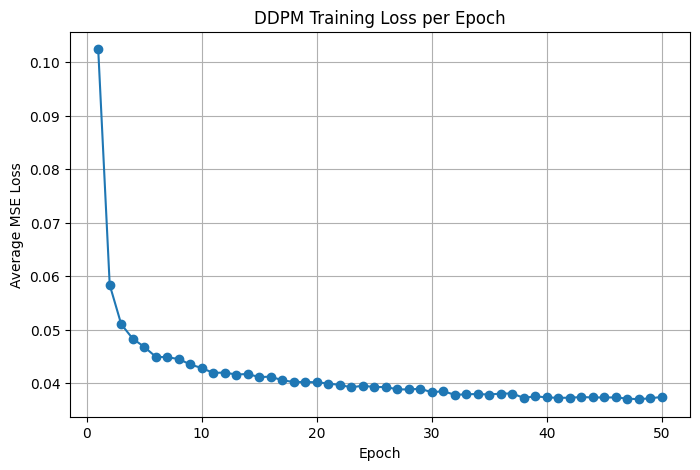

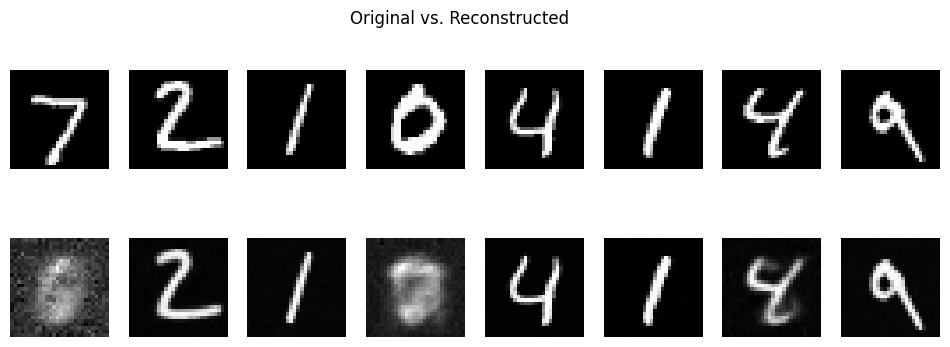

In [ ]:
import matplotlib.pyplot as plt

# 1) Loss curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(losses) + 1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average MSE Loss')
plt.title('DDPM Training Loss per Epoch')
plt.grid(True)
plt.show()

# 2) Original vs. Reconstructed
model.eval()
with torch.no_grad():
    imgs, _ = next(iter(test_loader))
    imgs = imgs.to(device)
    B = imgs.size(0)
    t = torch.randint(0, num_diffusion_steps, (B,), device=device)
    noise = torch.randn_like(imgs)
    a_bar_t = alpha_bar[t][:, None, None, None]
    noisy = torch.sqrt(a_bar_t) * imgs + torch.sqrt(1 - a_bar_t) * noise
    pred_noise = model(noisy, t)
    reconstructed = (noisy - torch.sqrt(1 - a_bar_t) * pred_noise) / torch.sqrt(a_bar_t)

n = min(8, B)
fig, axes = plt.subplots(2, n, figsize=(n * 1.5, 4))
for i in range(n):
    axes[0, i].imshow(imgs[i].cpu().squeeze(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
    axes[1, i].axis('off')
axes[0, 0].set_ylabel('Original', fontsize=12)
axes[1, 0].set_ylabel('Reconstructed', fontsize=12)
plt.suptitle('Original vs. Reconstructed')
plt.show()
